In [ ]:
import pandas as pd
import numpy as np
import string

from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import re
from sklearn.linear_model import LogisticRegressionCV

from sklearn.naive_bayes import MultinomialNB,BernoulliNB
from sklearn import metrics
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from nltk.stem import SnowballStemmer
# !pip install zeugma
from zeugma.embeddings import EmbeddingTransformer

from keras.models import Model,load_model
from keras.layers import Dense, Input, Dropout, LSTM, Activation,Bidirectional
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
from keras.initializers import glorot_uniform
from keras.callbacks import ModelCheckpoint
import IPython
from keras.optimizers import Adam
!pip install -q -U keras-tuner
import kerastuner as kt
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow import keras

In [ ]:
df_train=pd.read_csv("/data/train.csv")

In [ ]:
dfE_train=df_train.drop(["id","keyword","location"],axis=1)

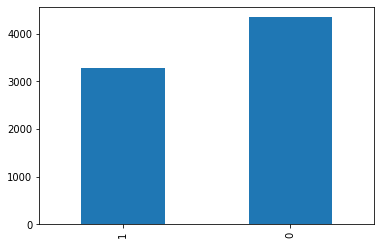

In [ ]:
#This Means we have an unbalanced dataset, we can try later to fix it if our model dont work that well.
dfE_train.target.value_counts().sort_values().plot(kind = 'bar')

In [ ]:
df_class_0 = dfE_train[dfE_train['target'] == 0]
df_class_1 = df_train[df_train['target'] == 1]

In [ ]:
df_class_0_under = df_class_0.sample(dfE_train.target.value_counts()[1])
dfE_train = pd.concat([df_class_0_under, df_class_1], axis=0)

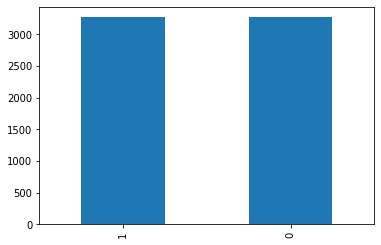

In [ ]:
dfE_train.target.value_counts().sort_values().plot(kind = 'bar')


In [ ]:
#This function removes consecutive characters 
def remove_repeating_char(text):
  return re.sub(r'(.)\1+', r'\1\1', text) 

def preprocess(text, stem=False):
    stemmer = SnowballStemmer('english') 
    text=text.lower().split()
    text=[i.strip("''") for i in text]
    tokens  = []
    L=["http","co","https","@","fvnl1ktpb1","test"]
    for s in text:
      s=remove_repeating_char(s)
      if s not in stop:
        for i in L:
          if  i in s:
            s=s.replace(i,"")
        if "t.ly/" not in s:
          tokens.append(s)
    return " ".join(tokens)

In [ ]:
dfE_train.text = dfE_train.text.apply(lambda x: preprocess(x))

In [ ]:
dfE_train.head()

,text,target,id,keyword,location
6756,i'm tornado looking soul take,0,NaN,NaN,NaN
5994,gets battlefield 3 screams mic cunts,0,NaN,NaN,NaN
2298,first unter league game another orianna happen...,0,NaN,NaN,NaN
907,eh hello ver bloody thighs bloody cleav.. ûó ...,0,NaN,NaN,NaN
2871,pizza drought anymore..,0,NaN,NaN,NaN


In [ ]:
glove = EmbeddingTransformer('glove')
X= glove.transform(dfE_train.text.to_numpy())

Testing with basic Deeplearning(TFIDF then GloVe)

In [ ]:

def read_glove_vecs(glove_file):
    with open(glove_file, 'r') as f:
        words = set()
        word_to_vec_map = {}
        for line in f:
            line = line.strip().split()
            curr_word = line[0]
            words.add(curr_word)
            word_to_vec_map[curr_word] = np.array(line[1:], dtype=np.float64)
        
        i = 1
        words_to_index = {}
        index_to_words = {}
        for w in sorted(words):
            words_to_index[w] = i
            index_to_words[i] = w
            i = i + 1
    return words_to_index, index_to_words, word_to_vec_map

    
def convert_to_one_hot(Y, C):
    Y = np.eye(C)[Y.reshape(-1)]
    return Y


def sentences_to_indices(X, word_to_index, max_len):

    
    m = X.shape[0]                                  
    

    X_indices = np.zeros((m,max_len))
    
    for i in range(m):                           
        sentence_words = [word.lower() for word in X[i].split()]
        table = str.maketrans('', '', string.punctuation)
        stripped = [w.translate(table) for w in sentence_words]
        j = 0
        for w in stripped:
            try:
              X_indices[i, j] = word_to_index[w]

              j = j + 1
            except Exception as e:
              continue
    return X_indices

def maxlenofdata(X):
  maxlen=0
  for i in X:
    ll=len(i.split())
    if ll>maxlen:
      maxlen=ll
  return maxlen


def fixing(X):
  Y=[]
  for i in range(len(X)):
    Y.append(np.argmax(X[i]))
  return Y


def pretrained_embedding_layer(word_to_vec_map, word_to_index):
    vocab_len = len(word_to_index) + 1                  
    emb_dim = word_to_vec_map["cucumber"].shape[0]      
    emb_matrix = np.zeros((vocab_len,emb_dim))
    for word, idx in word_to_index.items():
        emb_matrix[idx, :] = word_to_vec_map[word]
    embedding_layer = Embedding(vocab_len,emb_dim,trainable=False)
    embedding_layer.build((None,)) 
    embedding_layer.set_weights([emb_matrix])
    
    return embedding_layer




def polispor(input_shape, word_to_vec_map, word_to_index):

    sentence_indices = Input(input_shape, dtype='int32')

    embedding_layer = pretrained_embedding_layer(word_to_vec_map, word_to_index)

    embeddings = embedding_layer(sentence_indices)  

    X = LSTM(64, return_sequences = True)(embeddings)

    X = Dropout(0.5)(X)
    X = LSTM(160, return_sequences=False)(X)
    X = Dropout(0.5)(X)
    X = Dense(2)(X)
    X = Activation('softmax')(X)
    model = Model(inputs=sentence_indices, outputs=X)
    return model

In [ ]:
word_to_index, index_to_word, word_to_vec_map = read_glove_vecs('glove.6B.100d.txt')

In [ ]:
from sklearn.model_selection import train_test_split

data_train, data_test, labels_train1, labels_test1 = train_test_split(dfE_train.text.to_numpy(), dfE_train.target.to_numpy(), test_size=0.20, random_state=42)
max_len=maxlenofdata(data_train)
labels_train = convert_to_one_hot(labels_train1, C = 2)
labels_test = convert_to_one_hot(labels_test1, C = 2)

In [ ]:
data_train_indices=sentences_to_indices(data_train,word_to_index, max_len = max_len)
data_test_indices=sentences_to_indices(data_test,word_to_index, max_len = max_len)

In [ ]:
embedding_layer = pretrained_embedding_layer(word_to_vec_map, word_to_index)

In [ ]:
model = polispor((max_len,), word_to_vec_map, word_to_index)
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 25)]              0         
_________________________________________________________________
embedding (Embedding)        (None, 25, 100)           40000100  
_________________________________________________________________
lstm_2 (LSTM)                (None, 25, 64)            42240     
_________________________________________________________________
dropout_2 (Dropout)          (None, 25, 64)            0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 160)               144000    
_________________________________________________________________
dropout_3 (Dropout)          (None, 160)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 322 

In [ ]:
mc = ModelCheckpoint('best_model.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)
opt=Adam(learning_rate=0.001)
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

In [ ]:
history=model.fit(data_train_indices, labels_train, epochs = 50, batch_size = 128,validation_data=(data_test_indices,labels_test),verbose=1 ,shuffle=True,callbacks=[mc])

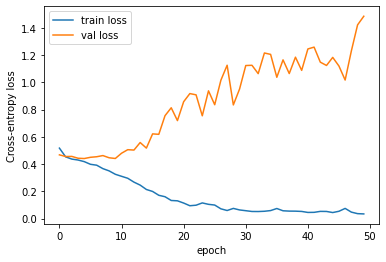

In [ ]:
plt.plot(history.history["loss"],label='train loss')
plt.plot(history.history["val_loss"],label='val loss')
plt.xlabel('epoch')
plt.ylabel('Cross-entropy loss')
plt.legend()

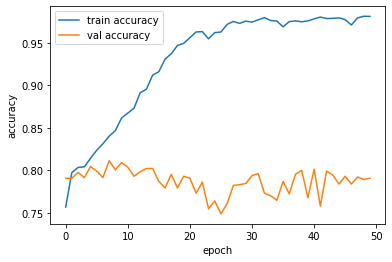

In [ ]:
plt.plot(history.history["accuracy"],label='train accuracy')
plt.plot(history.history["val_accuracy"],label='val accuracy')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend()

In [ ]:
saved_model = load_model('best_model.h5')

In [ ]:
data_test_indices = sentences_to_indices(data_test, word_to_index, max_len = max_len)
loss, acc = saved_model.evaluate(data_test_indices, labels_test)
print()
print("Test accuracy = ", acc)

41/41 [==============================] - 1s 5ms/step - loss: 0.4622 - accuracy: 0.8113

Test accuracy =  0.811306357383728


Tuning our simple model

In [ ]:
#Hyperparameter Tuning Cell
def simplenlpmodel2(hp):
    sentence_indices = Input((25,), dtype='int32')
    hp_units = hp.Int('units', min_value = 32, max_value = 512, step = 32)
    embeddings = embedding_layer(sentence_indices)  
    X = Bidirectional(LSTM(hp_units, return_sequences = False))(embeddings)
    X = Dropout(0.5)(X)
    X = Dense(2)(X)
    X = Activation('softmax')(X)
    model = Model(inputs=sentence_indices, outputs=X)
    hp_learning_rate = hp.Choice('learning_rate', values = [1e-2, 1e-3, 1e-4]) 
  
    model.compile(optimizer = keras.optimizers.Adam(learning_rate = hp_learning_rate),
                loss='categorical_crossentropy', 
                metrics = ['accuracy'])
    return model

def simpleH(hp):
    sentence_indices = Input((25,), dtype='int32') 
    hp_units1 = hp.Int('units1', min_value = 32, max_value = 512, step = 32)
    embeddings = embedding_layer(sentence_indices) 
    X = Bidirectional(LSTM(hp_units1, return_sequences = True))(embeddings)
    X = Dropout(0.5)(X)
    hp_units2 = hp.Int('units2', min_value = 32, max_value = 512, step = 32)
    X = Bidirectional(LSTM(hp_units2, return_sequences=False))(X)
    X = Dropout(0.5)(X)
    X = Dense(2)(X)
    X = Activation('softmax')(X)
    model = Model(inputs=sentence_indices, outputs=X)
    hp_learning_rate = hp.Choice('learning_rate', values = [1e-2, 1e-3, 1e-4]) 
  
    model.compile(optimizer = keras.optimizers.Adam(learning_rate = hp_learning_rate),
                loss='categorical_crossentropy', 
                metrics = ['accuracy'])
    return model





tuner=kt.RandomSearch(simpleH,objective='val_accuracy',max_trials=10,executions_per_trial=3,directory="my_dir",project_name="hyperparameter tuning2")
class ClearTrainingOutput(tf.keras.callbacks.Callback):
  def on_train_end(*args, **kwargs):
    IPython.display.clear_output(wait = True)



tuner.search(data_train_indices, labels_train,validation_data=(data_test_indices,labels_test), epochs = 10, callbacks = [ClearTrainingOutput()])

# Get the optimal hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials = 1)[0]

print(f"""The hyperparameter search is complete. The optimal number of units in the first bidirectional lstm is {best_hps.get('units1')} and the second bidirectional lstm units is {best_hps.get('units2')} the optimal learning rate for the optimizeris {best_hps.get('learning_rate')}.""")

Trial 10 Complete [00h 01m 23s]
val_accuracy: 0.80621337890625

Best val_accuracy So Far: 0.8141074577967325
Total elapsed time: 00h 16m 39s
INFO:tensorflow:Oracle triggered exit
The hyperparameter search is complete. The optimal number of units in the first bidirectional lstm is 64 and the second bidirectional lstm units is 160 the optimal learning rate for the optimizeris 0.001.
